In [60]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

In [61]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Input,Flatten,Reshape,AveragePooling2D,Dropout,LayerNormalization, ReLU,concatenate,Cropping2D, BatchNormalization
from keras.datasets import mnist
import tensorflow as tf

import keras
from keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint


In [62]:
image_path = '../dados/CAPTCHA-10k/teste'
def generate_df(image_path):
  label_path = '../dados/CAPTCHA-10k/labels10k'

  jpg_files = [f for f in os.listdir(image_path) if f.endswith('.jpg')]
  jpg_files.sort()
  data = []

  for jpg_file in jpg_files:
      txt_file = os.path.splitext(jpg_file)[0] + '.txt'
      txt_file_path = os.path.join(label_path, txt_file)

      if os.path.exists(txt_file_path):
          with open(txt_file_path, 'r') as file:
              txt_content = file.read().strip()

          data.append({'jpg_file': jpg_file, 'txt_content': txt_content})
  return pd.DataFrame(data)

df = generate_df(image_path)
df.head()

,jpg_file,txt_content
0,009001.jpg,JW4CZF
1,009002.jpg,H27LCM
2,009003.jpg,1EF8W0
3,009004.jpg,HZ1HQE
4,009005.jpg,97CZ9Z


In [63]:
df['txt_content'].str.len().value_counts()

txt_content
6    999
7      1
Name: count, dtype: int64

In [64]:
vocab = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', 'A', 'B',
       'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O',
       'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '*']
np.array(vocab)

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', 'A', 'B',
       'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O',
       'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '*'],
      dtype='<U1')

In [65]:
def preprocess(img):
  kernel  = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))
  img     = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
  _, img  = cv2.threshold(img, 90, 255, cv2.THRESH_BINARY)
  return img

In [66]:
def generate_X_Y(image_path):
  df = generate_df(image_path)
  X = [preprocess(cv2.imread(os.path.join(image_path, x),cv2.IMREAD_GRAYSCALE)) for x in df["jpg_file"]]
  X = np.array(X)
  X = np.expand_dims(X, axis=-1)

  X = X.astype('float32') / 255.

  
  return X,df['txt_content']

X_teste,labels_teste = generate_X_Y('../dados/CAPTCHA-10k/teste')

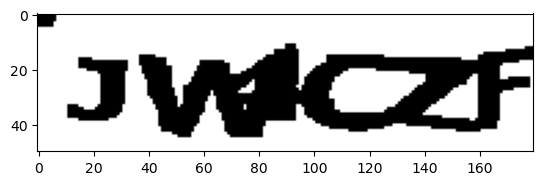

In [67]:
plt.imshow(X_teste[0], cmap='gray')

In [68]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def psnr(y_true, y_pred):
    max_pixel = 1.0
    return tf.image.psnr(y_true, y_pred, max_val=max_pixel)

In [69]:
autoencoder = tf.keras.models.load_model('model_BCE_aug_best_unet.tf',custom_objects={"rmse": rmse,"psnr":psnr})
classifier  = tf.keras.models.load_model('classifier_aug_best.tf')

In [70]:
X_teste_ae = autoencoder.predict(X_teste)

32/32 [==============================] - 1s 22ms/step


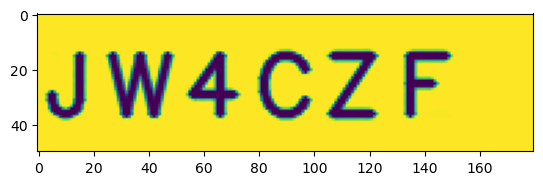

In [71]:
plt.imshow(X_teste_ae[0])

In [72]:
bins = np.arange(0,180,180//7)
bins

array([  0,  25,  50,  75, 100, 125, 150, 175])

In [73]:
from sklearn.preprocessing import OneHotEncoder

def get_x_y_classification(X_pred, labels):
    # Adjust labels if their length is not equal to 7
    labels = labels.apply(lambda x: x + '*' if len(x) != 7 else x)

    # Define bins
    num_parts = 7
    img_width = 180
    bins = np.arange(0,180,180//7)

    # Initialize lists to hold the split images and one-hot encoded labels
    x = []
    y = []

    # One-hot encoder for labels
    encoder = OneHotEncoder()

    # Fit the encoder on the labels (unique characters)
    encoder.fit(np.array(list(vocab)).reshape(-1, 1))

    # Process each image and corresponding label
    for img, label in zip(X_pred, labels):
        # Split the image into 7 parts
        for i in range(num_parts):
            start, end = bins[i], bins[i + 1]
            part_img = img[:, start:end,:]
            x.append(part_img)

            char = label[i]
            one_hot = encoder.transform([[char]])[0]
            y.append(one_hot.toarray())

    # Convert lists to numpy arrays
    x = np.array(x)
    y = np.array(y)
    y = np.squeeze(y, axis=1)
    return x, y

X_teste_class,Y_teste_class = get_x_y_classification(X_teste_ae,labels_teste)

In [90]:
Y_teste_pred = classifier.predict(X_teste_class)
Y_val_pred_class_indices = np.argmax(Y_teste_pred, axis=-1)
Y_val_pred_class_indices = Y_val_pred_class_indices.reshape(-1,7)

219/219 [==============================] - 1s 2ms/step


In [91]:
vocab_tensor = np.array(vocab)

In [92]:
all_preds = vocab_tensor[Y_val_pred_class_indices -1]
words = ["".join(list(word)) for word in all_preds]
words = [w.replace("*","") for w in words]
df["preds"] = words

In [93]:
def count_matches(row):
    txt_content = row['txt_content']
    pred = row['preds']
    return sum(1 for a, b in zip(txt_content, pred) if a == b)

# Apply the function to each row
df['matches'] = df.apply(count_matches, axis=1)
df.sort_values(by="matches").head(20)

,jpg_file,txt_content,preds,matches
66,009067.jpg,WMB8YMN,WMBYMN,3
392,009393.jpg,CM4EWL,CM?EVV,3
268,009269.jpg,PEXBOW,PTXB0W,4
70,009071.jpg,FVVTLX,FW7TLX,4
925,009926.jpg,YW1W2A,YWIW?A,4
250,009251.jpg,W0LHOI,W0LH0T,4
436,009437.jpg,F4UNWR,F4UNVP,4
144,009145.jpg,013UXD,O13UXO,4
117,009118.jpg,PO9WFA,P09WPA,4
338,009339.jpg,MVLXWL,MVEXW?,4


In [96]:
miss = (df["matches"] != df["txt_content"].str.len()).sum()
acc = (len(df) - miss)/len(df)
acc

0.843

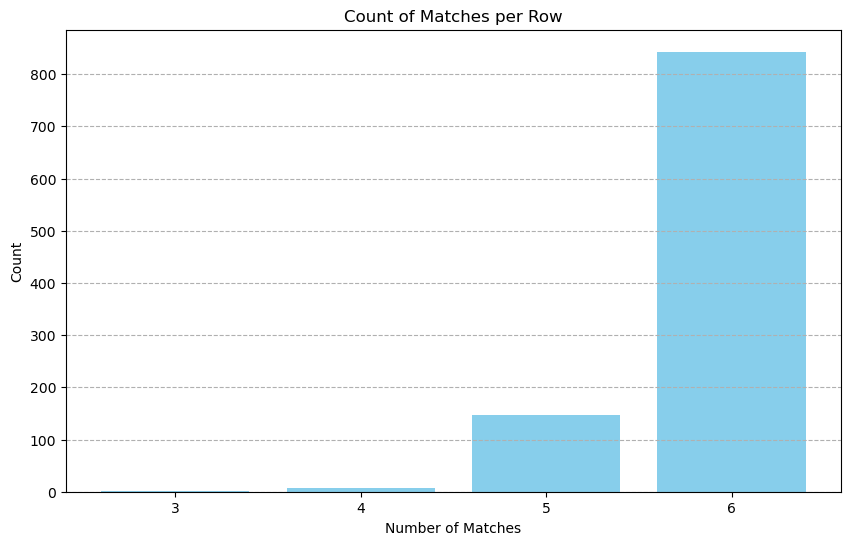

In [94]:
match_counts = df['matches'].value_counts().sort_index()

# Plot the bar plot
plt.figure(figsize=(10, 6))
plt.bar(match_counts.index, match_counts.values, color='skyblue')
plt.xlabel('Number of Matches')
plt.ylabel('Count')
plt.title('Count of Matches per Row')
plt.xticks(match_counts.index)  # Ensure x-axis labels match the match counts
plt.grid(axis='y', linestyle='--')

# Show the plot
plt.show()

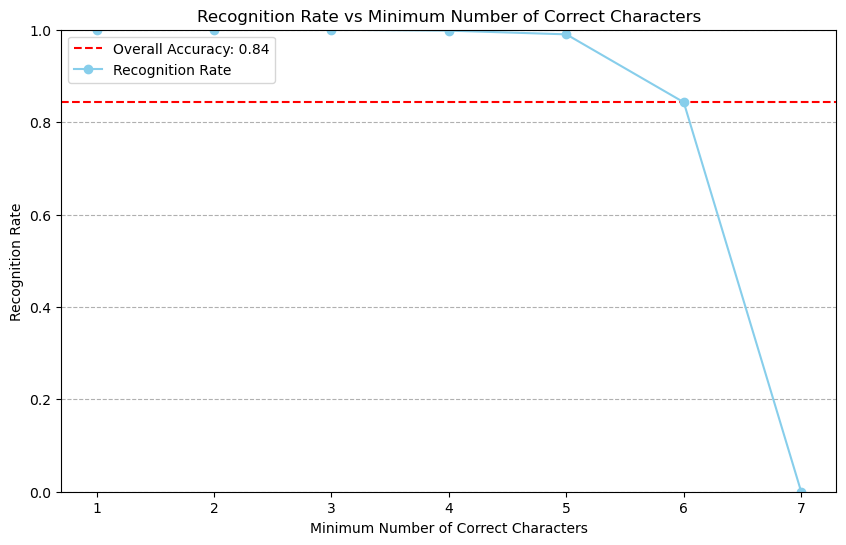

In [97]:
# Calculate recognition rates
max_chars = df['txt_content'].map(len).max()
recognition_rates = []

for min_correct in range(1, max_chars + 1):
    count_correct = df['matches'] >= min_correct
    rate = count_correct.mean()
    recognition_rates.append(rate)

# Plot the recognition rates
plt.figure(figsize=(10, 6))
plt.axhline(y=acc, color='r', linestyle='--', label=f'Overall Accuracy: {acc:.2f}')
plt.plot(range(1, max_chars + 1), recognition_rates, marker='o', color='skyblue', label='Recognition Rate')
plt.xlabel('Minimum Number of Correct Characters')
plt.ylabel('Recognition Rate')
plt.title('Recognition Rate vs Minimum Number of Correct Characters')
plt.grid(axis='y', linestyle='--')
plt.ylim(0, 1)
plt.xticks(range(1, max_chars + 1))
plt.legend()
plt.show()